#### Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
colors = ["#EA0000", "#2828FF", "#009100", "#F775000", "#FFD306"]
import csv

#### Read dataset

In [52]:
blob_test = np.genfromtxt("./dataset/PR_HW2_blob_test.csv", delimiter = ",", dtype=str)
blob_train = np.genfromtxt("./dataset/PR_HW2_blob_train.csv", delimiter = ",", dtype=str)
data_test = np.genfromtxt("./dataset/PR_HW2_test.csv", delimiter = ",", dtype=float)
data_train = np.genfromtxt("./dataset/PR_HW2_train.csv", delimiter = ",", dtype=float)
data_val = np.genfromtxt("./dataset/PR_HW2_val.csv", delimiter = ",", dtype=float)

#### FLD

In [53]:
class FLD:
    def __init__(self):
        self.mk = None
        self.m = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None
        self.nclasses = 0
        self.nfeatures = 0

    def fit(self, X, y):
        s = X.shape[0]
        N = np.zeros(self.nclasses)
        self.m = np.sum(X, axis = 0)/s
        self.mk = np.zeros((self.nclasses, self.nfeatures)) # num of class by num of features
        for i in range(s):
            N[y[i]] += 1
            self.mk[y[i]] += X[i]
        for i in range(self.nclasses):
            self.mk[i] /= N[i]
        self.sw = np.zeros((self.nfeatures,self. nfeatures))
        for k in range(self.nclasses):
            sk = np.zeros((self.nfeatures, self.nfeatures))
            for n in range(s):
                t = np.array([])
                if y[n] == k:
                    t = np.array(X[n]-self.mk[k]).reshape((self.nfeatures, 1))
                sk += (t @ t.T)
            self.sw += sk
        self.sb = np.zeros((self.nfeatures, self.nfeatures))
        for k in range(self.nclasses):
            t = np.array(self.mk[k] - self.m).reshape((self.nfeatures, 1))
            self.sb += N[k] * (t @ t.T)
        isw = np.linalg.pinv(self.sw)
        eigVal, eigVec = np.linalg.eig(isw @ self.sb)
        idx = np.argsort(-np.absolute(eigVal))
        w0 = np.real(eigVec[:, idx[0]].reshape((-1)))
        w1 = np.real(eigVec[:, idx[1]].reshape((-1)))
        self.w = np.array(w0)
        self.slope = np.array([w1[1]+0.5, w1[0]])
        return

    def predict_using_class_mean(self, X_test):
        y_pred = np.zeros(X_test.shape[0], dtype=int)
        fld_mk = self.mk @ self.w
        for i in range(X_test.shape[0]):
            fld_x = (X_test[i] @ self.w)
            class_dist = np.zeros(self.nclasses)
            for k in range(self.nclasses):
                class_dist[k] = (fld_x - fld_mk[k])*(fld_x - fld_mk[k])
            y_pred[i] = np.argmin(class_dist)
        return y_pred

    def predict_using_knn(self, X, y, X_test, k=1):
        y_pred = np.zeros(X_test.shape[0], dtype = int)
        fld_X = X @ self.w
        dist = np.zeros((X_test.shape[0], X.shape[0]))
        for i in range(X_test.shape[0]):
            fld_rlt = X_test[i] @ self.w
            for j in range(X.shape[0]):
                dist[i, j] = (fld_rlt - fld_X[j]) * (fld_rlt - fld_X[j])
            idx = np.argsort(dist[i])
            p = np.zeros(self.nclasses)
            for c in range(k):
                p[y[idx[c]]] += 1
            y_pred[i] = np.argmax(p)
        return y_pred

    def show_confusion_matrix(self, y, y_pred):
        con_matrix = np.zeros((self.nclasses, self.nclasses), dtype=int)
        for i in range(y.shape[0]):
            if y[i] == y_pred[i]:
                con_matrix[y[i], y[i]] += 1
            else:
                con_matrix[y[i], y_pred[i]] += 1
        plt.matshow(con_matrix,cmap=plt.cm.Blues, alpha=0.3)
        for i in range(self.nclasses):
            for j in range(self.nclasses):
                plt.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.title("confusion matrix")
        plt.xlabel("predict class")
        plt.ylabel("true class")
        plt.show()
        return

    def plot_projection(self, X, y):
        x_bar = np.linspace(-12,12,100)
        y_bar = self.slope[0] * x_bar + self.slope[1]
        plt.plot(x_bar,y_bar, color="#282828")
        s = X.shape[0]
        for k in range(self.nclasses-1, -1, -1):
            g = []
            for n in range(s):
                if y[n] == k:
                    pj = self.w[0] * X[n, 0] + self.w[1] * X[n, 1]
                    g.append([X[n, 0], X[n, 1]])
                    g.append([-pj, -self.slope[0]*pj+self.slope[1]])
                    plt.plot([X[n, 0], -pj], [X[n, 1], -self.slope[0]*pj+self.slope[1]], color = colors[k], linewidth = 0.5, alpha=0.3)
            g = np.array(g)
            plt.scatter(g[:, 0], g[:, 1], label = "class "+str(k), color = colors[k], alpha=0.5)
        for k in range(3):
            plt.scatter(self.mk[k][0], self.mk[k][1], color = colors[k], edgecolors="#050505")
        plt.legend()
        plt.title("["+str(self.slope[0])+", "+str(self.slope[1])+"]")
        plt.show()
        return

    def accuracy_score(self, y, y_pred):
        correct_pred = 0
        for i in range(y.shape[0]):
            if y[i] == y_pred[i]:
                correct_pred += 1
        print("accuracy score: "+str(float(correct_pred/y.shape[0])))
        return

#### Multiclass logistic regression

In [54]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.nclasses = 0
        self.nfeatures = 0
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def fit(self, X, y, batch_size=16, lr=0.01, epoch=100):
        for e in range(epoch):
            for b in range(int(X.shape[0]/batch_size)):
                gradient = np.zeros((self.nclasses, self.nfeatures+1))
                for j in range(self.nclasses):
                    for i in range(batch_size):
                        idx = b*batch_size + i
                        z = (X[idx] @ self.weights)
                        t = np.argmax(self.softmax(z))
                        gradient[j] += (t-y[idx])*X[idx]
                self.weights -= lr*gradient/batch_size
            self.epoch.append(e)
            self.train_loss.append(self.evaluate(X, y))
            if e % 50 == 0:
                lr /= 10
        plt.plot(self.epoch, self.train_loss)
        plt.show()
        return

    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            z = X[i] @ self.weights
            softmax_z = self.softmax(z)
            y_pred.append(np.argmax(softmax_z))
        return np.array(y_pred)

    def evaluate(self, X, y):
        Z = X @ self.weights
        probs = []
        for i in range(X.shape[0]):
            softmax_z = self.softmax(Z[i])
            probs.append(softmax_z)
        probs = np.array(probs)
        return self.cross_entropy(y, probs)

    def softmax(self, z):
        exp_z = np.exp(z)
        softmax_z = exp_z/np.sum(exp_z)
        return softmax_z

    def cross_entropy(self, y, probs):
        loss_ce = 0
        for i in range(y.shape[0]):
            loss_ce += -y[i]*np.log(probs[i, y[i]]+0.000000000001)
        return loss_ce
    
    def accuracy_score(self, y, y_pred):
        acc = 0
        for i in range(y.shape[0]):
            if y[i] == y_pred[i]:
                acc += 1
        print("accuracy score: "+str(float(acc/y.shape[0])))
        return

    def show_confusion_matrix(self, y, y_pred):
        con_matrix = np.zeros((self.nclasses, self.nclasses), dtype=int)
        for i in range(y.shape[0]):
            if y[i] == y_pred[i]:
                con_matrix[y[i], y[i]] += 1
            else:
                con_matrix[y[i], y_pred[i]] += 1
        plt.matshow(con_matrix,cmap=plt.cm.Blues, alpha=0.3)
        for i in range(self.nclasses):
            for j in range(self.nclasses):
                plt.text(x=j, y=i,s=con_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.title("confusion matrix")
        plt.xlabel("predict class")
        plt.ylabel("true class")
        plt.show()
        return

#### Q1~Q12

##### Preprocess input data

In [55]:
X_train = np.asarray(blob_train[1:, :2], dtype = "float64")
y_train = np.asarray(blob_train[1:, 2], dtype = int)

X_test = np.asarray(blob_test[1:, :2], dtype = "float64")
y_test = np.asarray(blob_test[1:, 2], dtype = int)

train_size = X_train.shape[0]
test_size = X_test.shape[0]

nfeatures = 2
nclasses = 3

##### Logistic regression

[[1.98 0.66 1.8 ]
 [2.64 0.88 2.4 ]
 [4.95 1.65 4.5 ]]


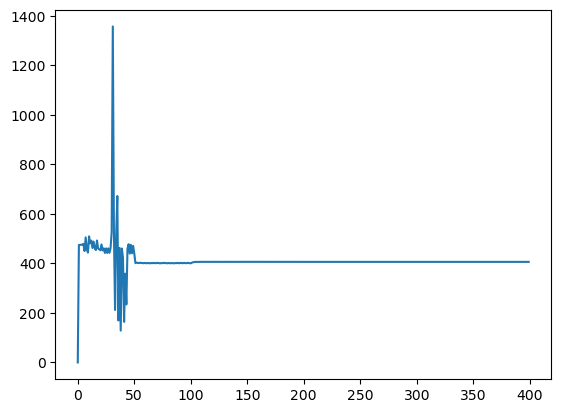

accuracy score: 0.894


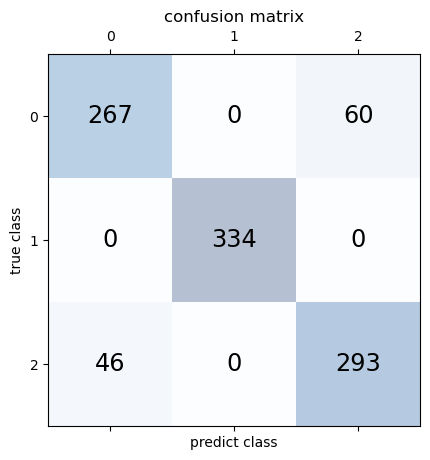

[[2.88481351 1.34601992 3.03986149]
 [3.54481351 1.56601992 3.63986149]
 [5.85481351 2.33601992 5.73986149]]


In [56]:
X_train_bar = np.concatenate((X_train, np.ones((train_size, 1))), axis=1) # X with 1s
X_test_bar = np.concatenate((X_test, np.ones((test_size, 1))), axis=1)
weights = np.ones((nclasses,nfeatures+1))
weights[0] = weights[0] - 0.4
weights[1] = weights[1] - 0.2
weights[2] = weights[2] + 0.5
weights[:, 0] = weights[:, 0] * 3.3
weights[:, 1] = weights[:, 1] * 1.1
weights[:, 2] = weights[:, 2] * 3

print(weights)
lg_reg = MultiClassLogisticRegression()
lg_reg.nclasses = nclasses
lg_reg.nfeatures = nfeatures
lg_reg.weights = weights
lg_reg.fit(X_train_bar, y_train, batch_size=100, lr =1.05, epoch = 400)
y_pred = lg_reg.predict(X_train_bar)
lg_reg.accuracy_score(y_train, y_pred)
lg_reg.show_confusion_matrix(y_train, y_pred)
print(lg_reg.weights)

###### predict testing data

accuracy score: 0.883


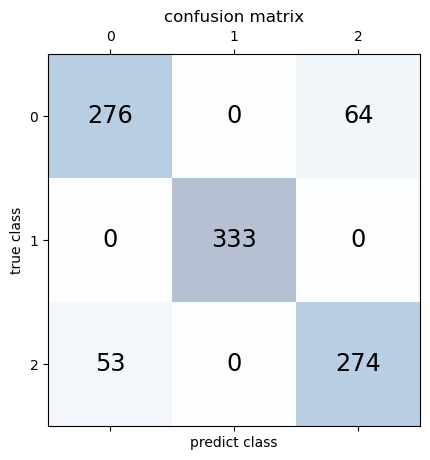

In [57]:
y_pred = lg_reg.predict(X_test_bar)
lg_reg.accuracy_score(y_test, y_pred)
lg_reg.show_confusion_matrix(y_test, y_pred)

##### FLD

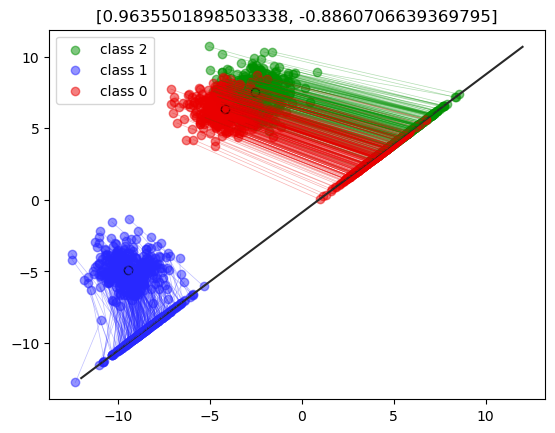

In [58]:
fld = FLD()
fld.nclasses = nclasses
fld.nfeatures = nfeatures
fld.fit(X_train, y_train)
fld.plot_projection(X_train, y_train)

##### Using class mean to predict

[340 333 327]


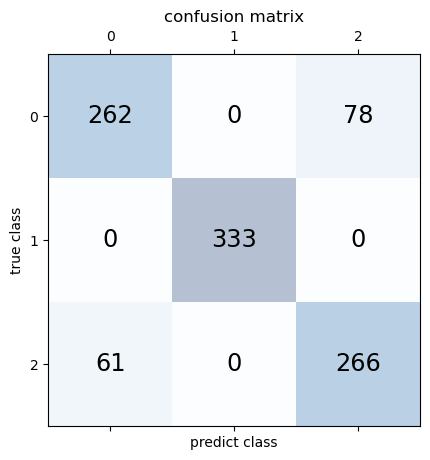

accuracy score: 0.861


In [59]:
y_pred = fld.predict_using_class_mean(X_test)
c = np.zeros(3, dtype=int)
for i in range(y_test.shape[0]):
    c[y_test[i]] += 1
print(c)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

##### Using K-NN to predict

###### k = 1

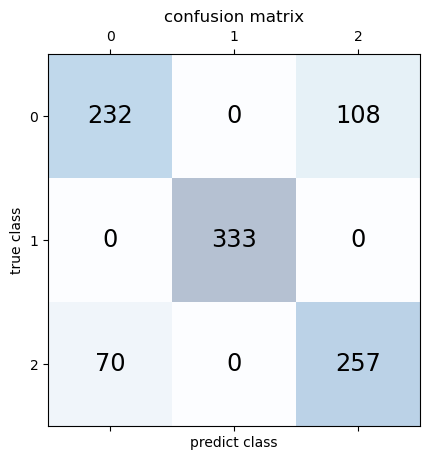

accuracy score: 0.822


In [60]:
y_pred = fld.predict_using_knn(X_train, y_train, X_test, k = 1)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

###### k = 2

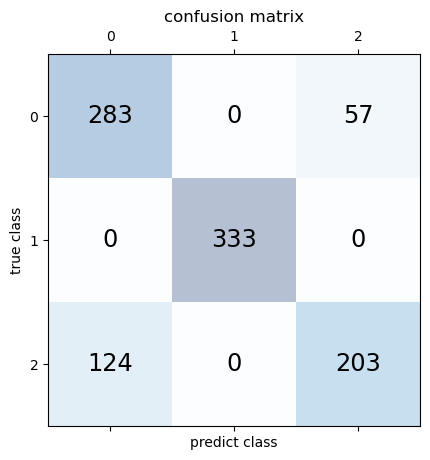

accuracy score: 0.819


In [61]:
y_pred = fld.predict_using_knn(X_train, y_train, X_test, k = 2)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

###### k = 3

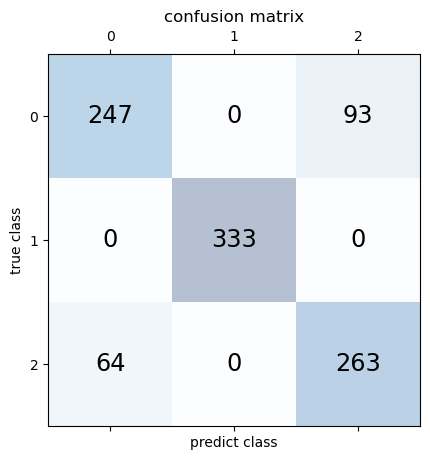

accuracy score: 0.843


In [62]:
y_pred = fld.predict_using_knn(X_train, y_train, X_test, k = 3)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

###### k = 4

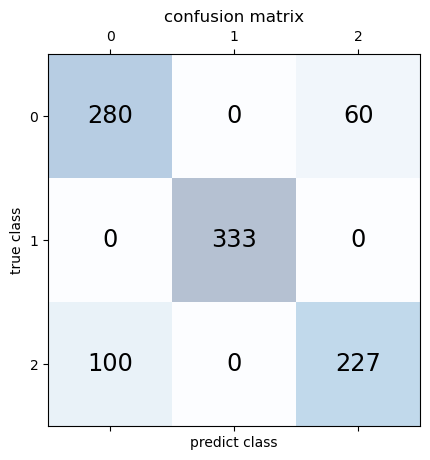

accuracy score: 0.84


In [63]:
y_pred = fld.predict_using_knn(X_train, y_train, X_test, k = 4)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

###### k = 5

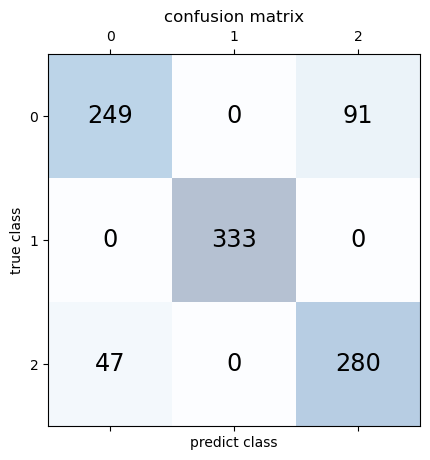

accuracy score: 0.862


In [64]:
y_pred = fld.predict_using_knn(X_train, y_train, X_test, k = 5)
fld.show_confusion_matrix(y_test, y_pred)
fld.accuracy_score(y_test, y_pred)

##### Train my model

[[-29.08377555 -25.88741884 -23.7807464 ]
 [-34.28377555 -31.08741884 -28.9807464 ]
 [-50.38377555 -47.18741884 -45.0807464 ]]


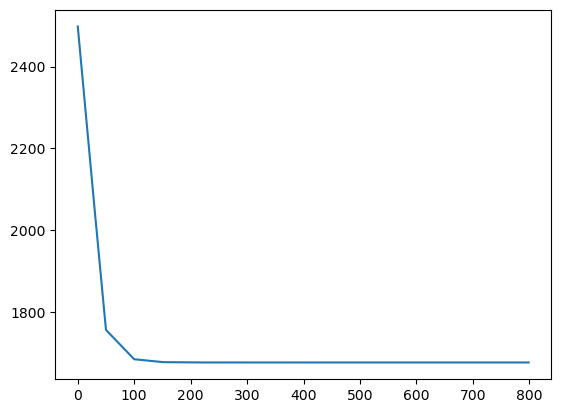

accuracy score: 0.34383561643835614


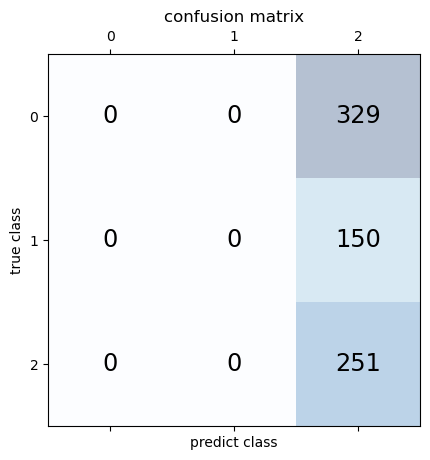

[[-70.4675511  -61.37483768 -60.0614928 ]
 [-75.6675511  -66.57483768 -65.2614928 ]
 [-91.7675511  -82.67483768 -81.3614928 ]]


In [69]:
m_X_train = np.asarray(data_train[1:, 2:4], dtype = "float64")
m_y_train = np.asarray(data_train[1:, 4], dtype = "int")
m_X_val = np.asarray(data_val[1:, 2:4], dtype = "float64")
m_y_val = np.asarray(data_val[1:, 4], dtype = "int")
m_X_test = np.asarray(data_test[1:, 2:4], dtype = "float64")

my_fld = FLD()
my_fld.nclasses = 3
my_fld.nfeatures = 2
my_fld.fit(m_X_train, m_y_train)
isw = np.linalg.pinv(my_fld.sw)
eigVal, eigVec = np.linalg.eig(isw @ my_fld.sb)
idx = np.argsort(-np.absolute(eigVal))
w = []
w.append(eigVec[:, idx[0]].reshape(-1))
w.append(eigVec[:, idx[1]].reshape(-1))
w = np.array(w)
fld_X_train = []
fld_X_val = []
for i in range(m_X_train.shape[0]):
    fld_X_train.append([w[0] @ m_X_train[i].T, w[1] @ m_X_train[i].T])
fld_X_train = np.array(fld_X_train)

for i in range(m_X_val.shape[0]):
    fld_X_val.append([w[0] @ m_X_val[i].T, w[1] @ m_X_val[i].T])
fld_X_val = np.array(fld_X_val)

fld_X_train = np.concatenate((fld_X_train, np.ones((fld_X_train.shape[0], 1))), axis=1)
fld_X_val = np.concatenate((fld_X_val, np.ones((fld_X_val.shape[0], 1))), axis=1)

# k = 5
# dists = np.zeros((fld_X_val.shape[0], fld_X_train.shape[0]))
# m_y_pred = np.zeros(fld_X_val.shape[0])
# for i in range(fld_X_val.shape[0]):
#     for j in range(fld_X_train.shape[0]):
#         dists[i, j] = (fld_X_val[i, 0] - fld_X_train[j, 0])*(fld_X_val[i, 0] - fld_X_train[j, 0]) + (fld_X_val[i, 1] - fld_X_train[j, 1]) * (fld_X_val[i, 1] - fld_X_train[j, 1])
#     sort_idx = np.argsort(dists[i])
#     p = np.zeros(3)
#     for m in range(k):
#         p[m_y_train[sort_idx[m]]] += 1
#     m_y_pred[i] = np.argmax(p)
# my_fld.accuracy_score(m_y_val, y_pred)
weights = np.array([[-29.08377555, -25.88741884, -23.7807464 ], [-34.28377555, -31.08741884, -28.9807464 ], [-50.38377555, -47.18741884, -45.0807464 ]])
print(weights)
m_lg_reg = MultiClassLogisticRegression()
m_lg_reg.nclasses = 3
m_lg_reg.nfeatures = 2
m_lg_reg.weights = weights
m_lg_reg.fit(fld_X_train, m_y_train, batch_size=1703, lr =5, epoch = 800)
y_pred = m_lg_reg.predict(fld_X_val)
m_lg_reg.accuracy_score(m_y_val, y_pred)
m_lg_reg.show_confusion_matrix(m_y_val, y_pred)
print(m_lg_reg.weights)

In [66]:
with open("311554040_prediction.csv", "w", newline='') as outputFile:
    w = csv.writer(outputFile)
    w.writerow(["Feature1", "Feature2", "Feature3", "Feature4", "Target"])
    for i in range(y_pred.shape[0]):
        l = np.concatenate((data_test[i+1, :4], np.array([y_pred[i]])))
        w.writerow(l)